Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import SparseCategoricalCrossentropy  # Import sparse categorical cross-entropy


%matplotlib inline

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
## https://drive.google.com/drive/folders/1X8HzdeNTmu0c3nhSH14UHognpTF9tv0X?usp=drive_link
drive.mount('/content/gdrive')
##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
# !pwd
#!ls
#!ls gdrive/MyDrive/'Skin cancer ISIC The International Skin Imaging Collaboration'/Test
data_dir_train = pathlib.Path("gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

print("Directory exists:", data_dir_train.exists())
print("Directory exists:", data_dir_test.exists())


Directory exists: True
Directory exists: True


In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180
image_size = (180,180)
shuffle = True
num_classes = 9
validation_split = 0.2

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=shuffle,
    validation_split=validation_split,
    subset = "training",
    seed=123  # You can set a seed for reproducibility
)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=shuffle,
    validation_split=validation_split,
    subset = "validation",
    seed=123  # You can set a seed for reproducibility
)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)



['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

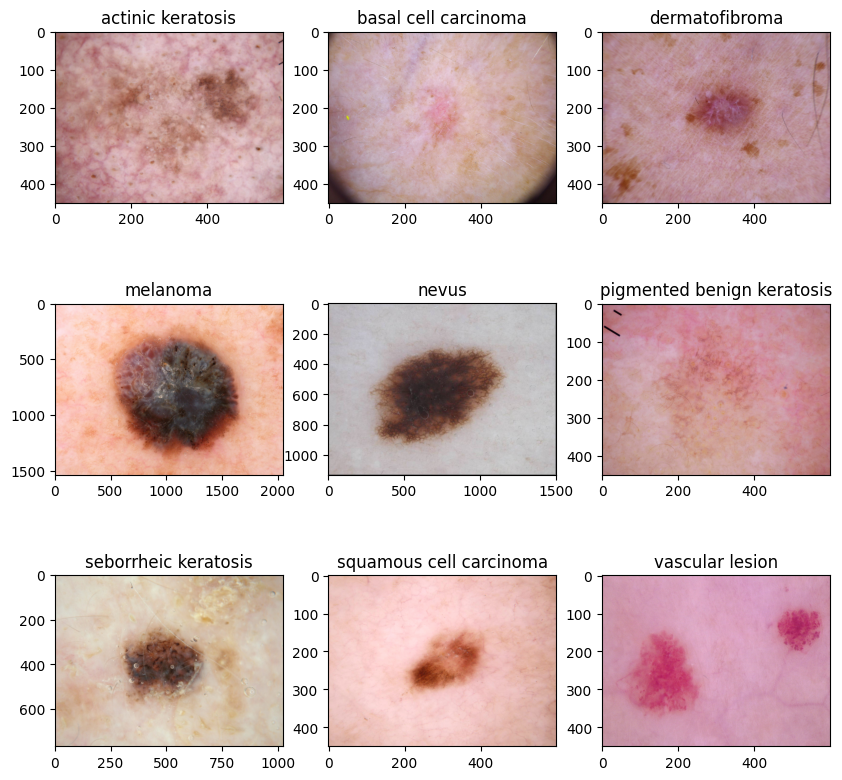

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Your code goes here

model = Sequential()

# Define the target size to which you want to rescale the images
target_size = (180,180)
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(target_size[0], target_size[1], 3)))

## Adding the 3 layers for the CNN
model.add(Conv2D(32, (3, 3), padding='same',input_shape=(180,180)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(512,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
#model.add(Dropout(0.5))    ## Currently dropout is configured.
model.add(Dense(num_classes))
model.add(Activation('softmax'))


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 batch_normalization (Batch  (None, 180, 180, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 178, 178, 32)      0         
                                                        

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 568s 2s/step - loss: 41.8813 - accuracy: 0.2935 - val_loss: 58.2663 - val_accuracy: 0.0582
Epoch 2/20
56/56 [==============================] - 6s 109ms/step - loss: 17.1503 - accuracy: 0.3761 - val_loss: 45.9019 - val_accuracy: 0.0828
Epoch 3/20
56/56 [==============================] - 6s 111ms/step - loss: 8.9040 - accuracy: 0.4414 - val_loss: 33.3400 - val_accuracy: 0.1588
Epoch 4/20
56/56 [==============================] - 6s 110ms/step - loss: 4.9332 - accuracy: 0.4760 - val_loss: 23.6848 - val_accuracy: 0.1499
Epoch 5/20
56/56 [==============================] - 6s 111ms/step - loss: 3.1299 - accuracy: 0.4754 - val_loss: 12.3668 - val_accuracy: 0.1499
Epoch 6/20
56/56 [==============================] - 6s 108ms/step - loss: 2.2857 - accuracy: 0.5089 - val_loss: 5.3359 - val_accuracy: 0.2327
Epoch 7/20
56/56 [==============================] - 6s 114ms/step - loss: 1.8574 - accuracy: 0.5285 - val_loss: 3.5551 - val_accuracy: 0.1655
Epoch 8/20


### Visualizing training results

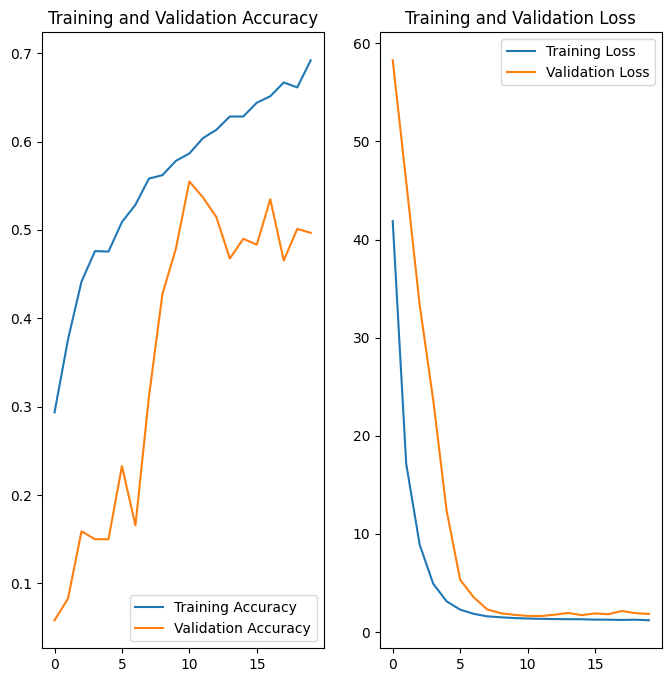

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
As we can see a large difference between the training and the validation data set , it points to overfitting happening. By bringing in the dropout layer and choosing the

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

### Todo:
### Create the model, compile and train the model


In [16]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
### Your code goes here

model1 = Sequential()

# Define the target size to which you want to rescale the images
target_size = (180,180)
model1.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(target_size[0], target_size[1], 3)))

## Adding the 3 layers for the CNN
model1.add(Conv2D(32, (3, 3), padding='same',input_shape=(180,180)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(Conv2D(32, (3, 3)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))


model1.add(Conv2D(64, (3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(Conv2D(64, (3, 3)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))


model1.add(Flatten())
model1.add(Dense(512,kernel_regularizer=l2(0.01)))
model1.add(Activation('relu'))
model1.add(Dropout(0.25))    ## Currently dropout is configured.
model1.add(Dense(num_classes))
model1.add(Activation('softmax'))


### Compiling the model

In [17]:
## Your code goes here

model1.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# View the summary of all layers
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 activation_6 (Activation)   (None, 180, 180, 32)      0         
                                                                 
 batch_normalization_4 (Bat  (None, 180, 180, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 activation_7 (Activation)   (None, 178, 178, 32)      0         
                                                      

### Training the model

In [18]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 11s 113ms/step - loss: 51.6947 - accuracy: 0.3002 - val_loss: 63.6007 - val_accuracy: 0.2081
Epoch 2/20
56/56 [==============================] - 6s 111ms/step - loss: 22.4348 - accuracy: 0.2812 - val_loss: 50.4855 - val_accuracy: 0.0850
Epoch 3/20
56/56 [==============================] - 6s 109ms/step - loss: 13.1550 - accuracy: 0.3225 - val_loss: 36.8186 - val_accuracy: 0.0828
Epoch 4/20
56/56 [==============================] - 6s 109ms/step - loss: 7.7602 - accuracy: 0.3945 - val_loss: 22.1571 - val_accuracy: 0.1387
Epoch 5/20
56/56 [==============================] - 6s 107ms/step - loss: 4.8577 - accuracy: 0.4381 - val_loss: 11.0176 - val_accuracy: 0.1946
Epoch 6/20
56/56 [==============================] - 6s 108ms/step - loss: 3.4073 - accuracy: 0.4481 - val_loss: 5.8155 - val_accuracy: 0.2170
Epoch 7/20
56/56 [==============================] - 6s 108ms/step - loss: 2.6102 - accuracy: 0.4336 - val_loss: 3.5111 - val_accuracy: 0.22

### Visualizing the results

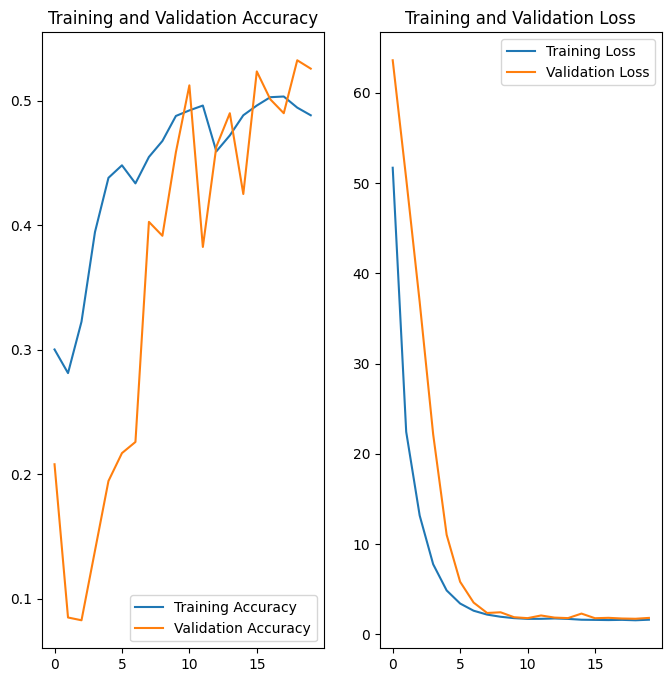

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

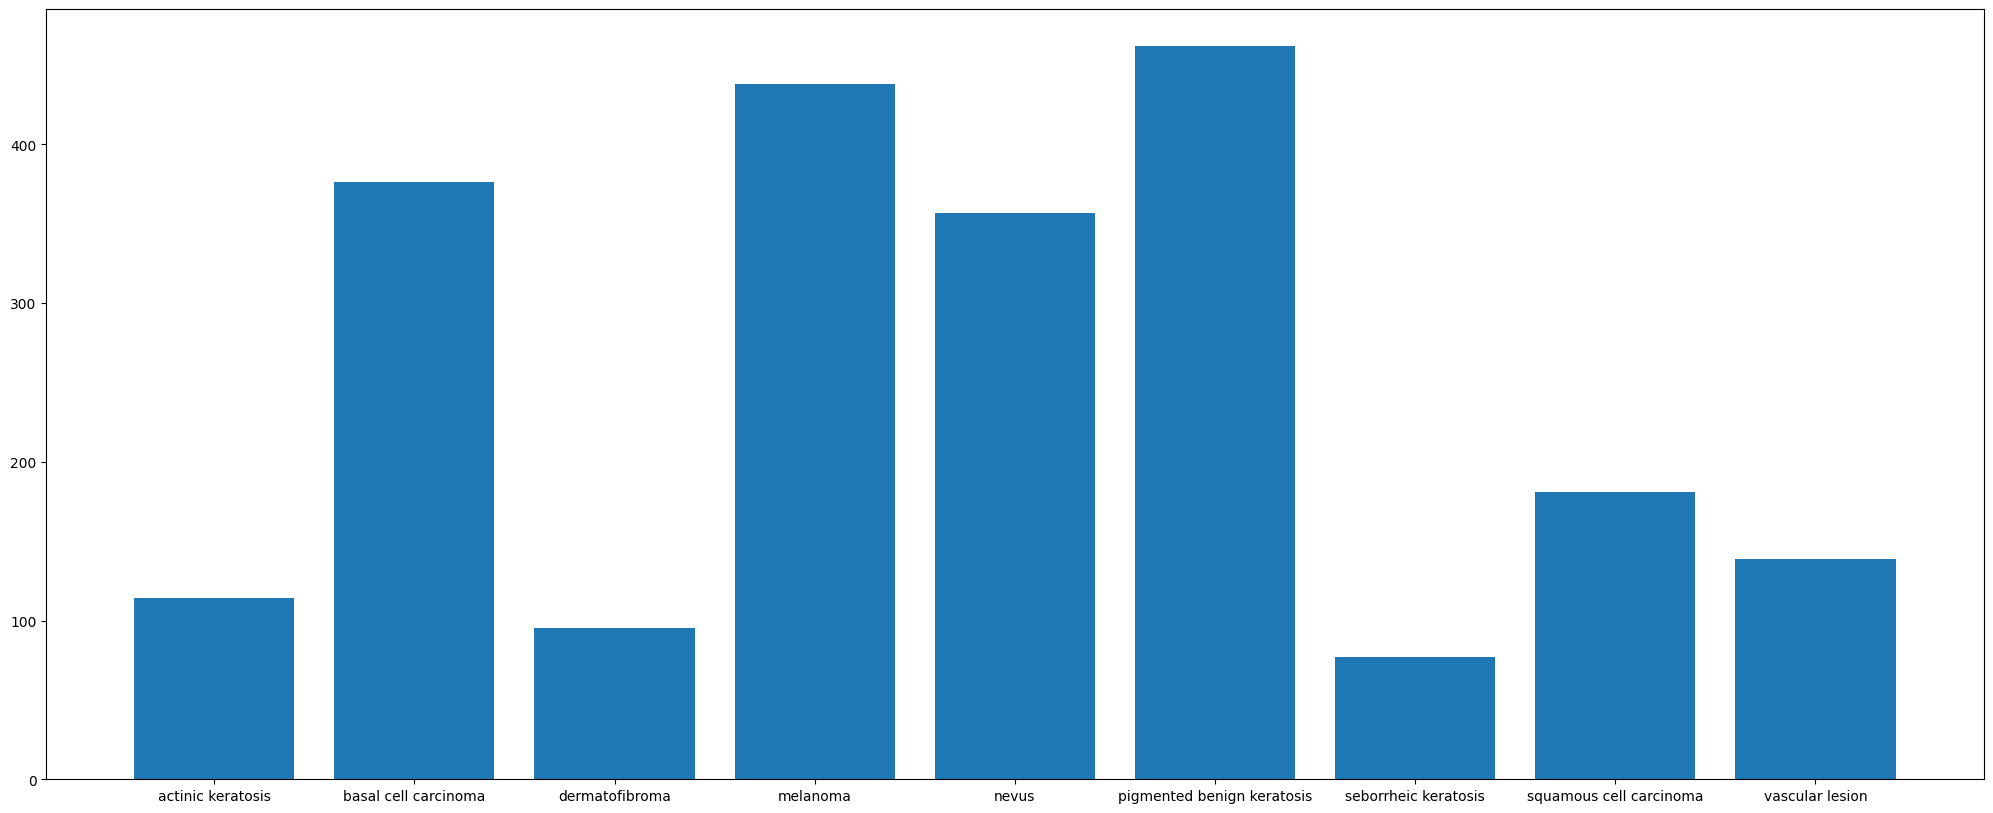

In [20]:
path_list=[]
lesion_list=[]
for i in class_names:

    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?

The seborrheic keratosis class has the least number of samples

#### - Which classes dominate the data in terms proportionate number of samples?

The basal cell carcinoma, melanoma and pigmented benign keratosis are the classes that dominate in terms pf proportionate number of samples.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [21]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [22]:
path_to_training_dataset="gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
!ls gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/


import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

ls: cannot access 'gdrive/MyDrive/Skin': No such file or directory
ls: cannot access 'cancer': No such file or directory
ls: cannot access 'ISIC': No such file or directory
ls: cannot access 'The': No such file or directory
ls: cannot access 'International': No such file or directory
ls: cannot access 'Skin': No such file or directory
ls: cannot access 'Imaging': No such file or directory
ls: cannot access 'Collaboration/Train/': No such file or directory
Initialised with 114 image(s) found.
Output directory set to gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDABB0A2680>: 100%|██████████| 500/500 [00:23<00:00, 21.53 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDA0022B9D0>: 100%|██████████| 500/500 [00:22<00:00, 21.75 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDA22750610>: 100%|██████████| 500/500 [00:21<00:00, 23.16 Samples/s]


Initialised with 438 image(s) found.
Output directory set to gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FDA2067C220>: 100%|██████████| 500/500 [01:37<00:00,  5.15 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FDA0027D5D0>: 100%|██████████| 500/500 [01:17<00:00,  6.41 Samples/s]


Initialised with 462 image(s) found.
Output directory set to gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FDA005530D0>: 100%|██████████| 500/500 [00:19<00:00, 26.09 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FDA204AA230>: 100%|██████████| 500/500 [00:40<00:00, 12.32 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FDA0022A0E0>: 100%|██████████| 500/500 [00:18<00:00, 27.52 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDA2046D4E0>: 100%|██████████| 500/500 [00:18<00:00, 26.97 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [23]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [24]:
from glob import glob

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011185.jpg_ed9d88a1-2a6c-4cc0-9992-004676fc134f.jpg',
 'gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010402.jpg_249a5973-2a3b-402a-abff-446b9c7b39ec.jpg',
 'gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000305.jpg_ea9f32a7-9e31-4b8e-8253-2e58cdbcd98b.jpg',
 'gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010350.jpg_e2e7644e-7451-469c-8b11-126f776c3a04.jpg',
 'gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000521.jpg_bc974b5f-514d-44ec-a575-141a0ece2bb4.jpg',
 'gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/mela

In [25]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [26]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [27]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)
new_df = pd.concat([original_df, df2], ignore_index=True)

In [28]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [29]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [30]:
data_dir_train= pathlib.Path("gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [31]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [32]:
model2 = Sequential()

# Define the target size to which you want to rescale the images
target_size = (180,180)
model2.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(target_size[0], target_size[1], 3)))

## Adding the 3 layers for the CNN
model2.add(Conv2D(32, (3, 3), padding='same',input_shape=(180,180)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))


model2.add(Conv2D(64, (3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))


model2.add(Flatten())
model2.add(Dense(512,kernel_regularizer=l2(0.01)))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))    ## Currently dropout is configured.
model2.add(Dense(num_classes))
model2.add(Activation('softmax'))


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [33]:
# compile the model
model2.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# View the summary of all layers
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 activation_12 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 batch_normalization_8 (Bat  (None, 180, 180, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 activation_13 (Activation)  (None, 178, 178, 32)      0         
                                                      

#### **Todo:**  Train your model

In [34]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 52s 282ms/step - loss: 26.9499 - accuracy: 0.1903 - val_loss: 20.7411 - val_accuracy: 0.0928
Epoch 2/30
169/169 [==============================] - 45s 259ms/step - loss: 5.9026 - accuracy: 0.2081 - val_loss: 3.8456 - val_accuracy: 0.0958
Epoch 3/30
169/169 [==============================] - 44s 255ms/step - loss: 2.7119 - accuracy: 0.1983 - val_loss: 2.3006 - val_accuracy: 0.2398
Epoch 4/30
169/169 [==============================] - 48s 272ms/step - loss: 2.1872 - accuracy: 0.2001 - val_loss: 2.1657 - val_accuracy: 0.1871
Epoch 5/30
169/169 [==============================] - 45s 259ms/step - loss: 2.0696 - accuracy: 0.2118 - val_loss: 2.0064 - val_accuracy: 0.2554
Epoch 6/30
169/169 [==============================] - 45s 261ms/step - loss: 2.0521 - accuracy: 0.2070 - val_loss: 1.9310 - val_accuracy: 0.2457
Epoch 7/30
169/169 [==============================] - 44s 250ms/step - loss: 2.2144 - accuracy: 0.2103 - val_loss: 2.9770 - val_accuracy: 0

#### **Todo:**  Visualize the model results

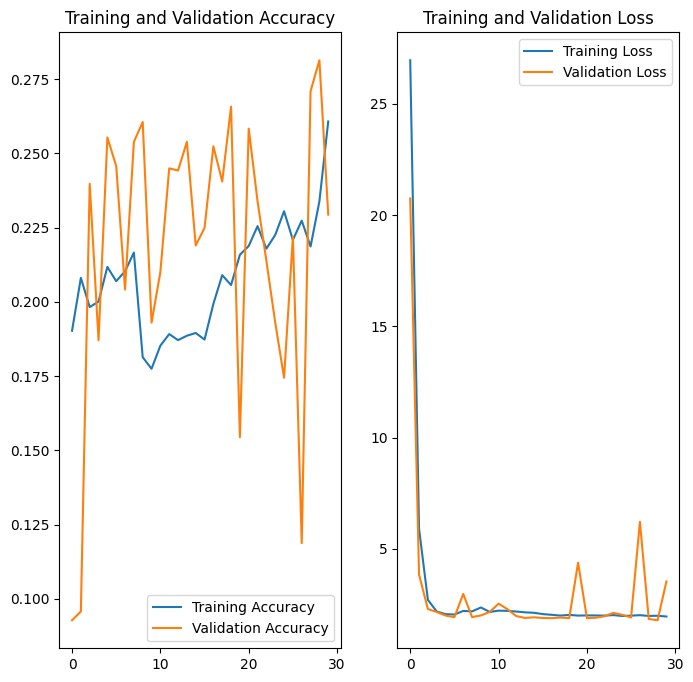

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Accuracy of the model increased with the Augmentor functions
Model is still overfitting, need to chnage the weights / hyperparameters to increase the accuracy